In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Epoch 1/2: 100%|██████████| 200/200 [08:33<00:00,  2.57s/it]


Epoch [1/2] | Loss: 0.5714


Epoch 2/2: 100%|██████████| 200/200 [08:31<00:00,  2.56s/it]


Epoch [2/2] | Loss: 0.5352


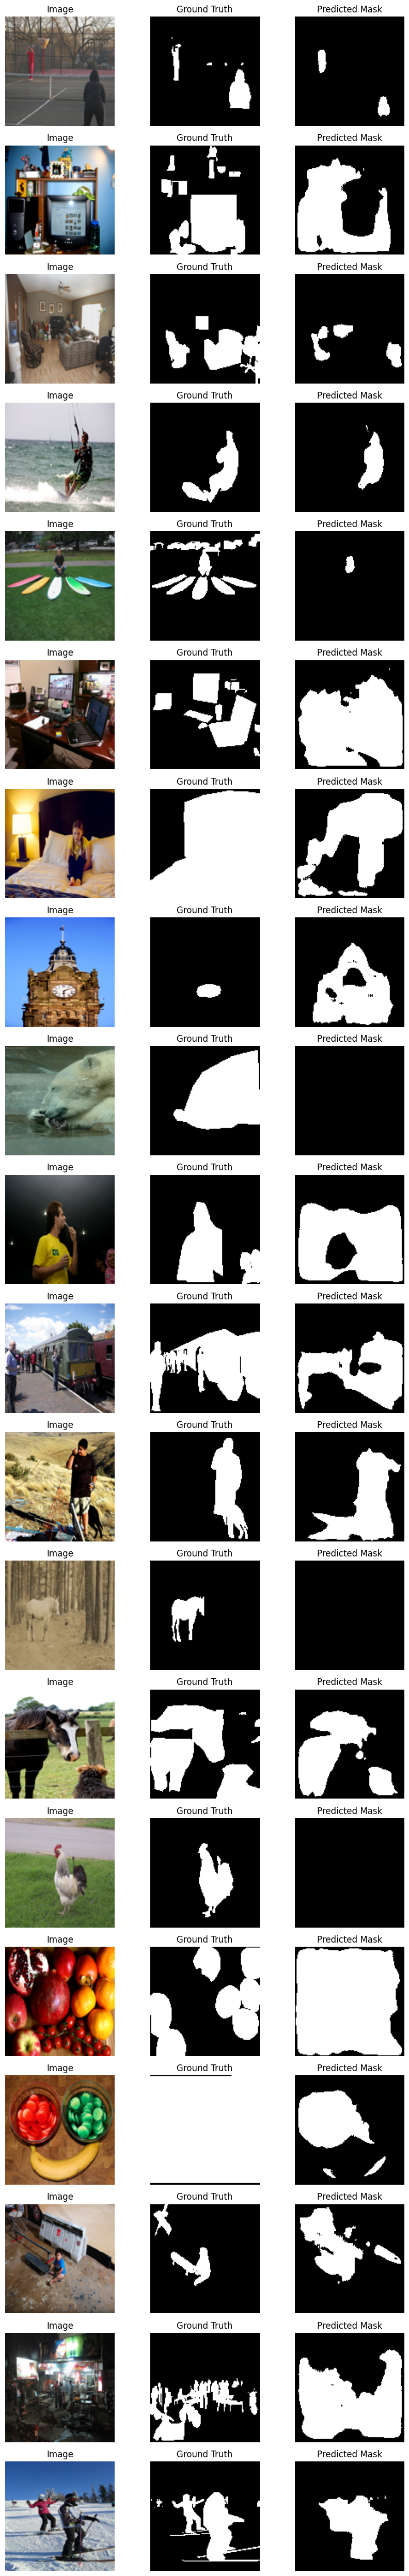

In [13]:
# ======================================================
#  🧠 COCO Segmentation → Dataset → U-Net → Train → Visualize
# ======================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# ======================================================
# 1️⃣  PATHS 
# ======================================================
train_img_dir = "/kaggle/working/seg_demo/images"
train_mask_dir = "/kaggle/working/seg_demo/masks"

# ======================================================
# 2️⃣  DATASET CLASS
# ======================================================
class CocoBinaryMaskDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = image.resize((128, 128))
        mask = mask.resize((128, 128))

        image = np.array(image) / 255.0
        mask = np.array(mask)
        mask = (mask > 127).astype(np.float32)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

# ======================================================
# 3️⃣  U-NET MODEL
# ======================================================
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super().__init__()
        self.down1 = DoubleConv(in_c, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottom = DoubleConv(256, 512)

        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_c, 1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        b = self.bottom(p3)

        u1 = self.up1(b)
        u1 = torch.cat([u1, d3], dim=1)
        u1 = self.conv1(u1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)
        u3 = self.conv3(u3)

        return self.final_conv(u3)

# ======================================================
# 4️⃣  TRAINING SETUP
# ======================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
dataset = CocoBinaryMaskDataset(train_img_dir, train_mask_dir)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = UNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ======================================================
# 5️⃣  TRAIN LOOP 
# ======================================================
epochs = 2
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss/len(loader):.4f}")

# ======================================================
# 6️⃣  VISUALIZE OUTPUTS 
# ======================================================
model.eval()
num_images = 20  # number of samples to visualize
fig, axes = plt.subplots(num_images, 3, figsize=(9, num_images*2.5))

for i in range(num_images):
    image, mask = dataset[i]
    image = image.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = torch.sigmoid(model(image))
        pred = (pred > 0.5).float().cpu().squeeze().numpy()

    axes[i, 0].imshow(image.cpu().squeeze().permute(1, 2, 0))
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask.squeeze(), cmap="gray")
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred, cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()